In [1]:
# import the libraries
import cashladder as c
import lusid
import lusid.models as models
import os
import sample_login
from lusidjam import RefreshingToken
import uuid
from datetime import datetime, timedelta
import pytz
from collections import namedtuple

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path,
    app_name="LusidJupyterNotebook")

# create a key for the LUSID instrument identifier for easier use
LUSID_INSTRUMENT_IDENTIFIER = "Instrument/default/LusidInstrumentId"

In [2]:
TransactionSpec = namedtuple(
    'TransactionSpec', 
    'id price trade_date settlement_date currency'
)

def build_transaction(transaction_spec):
    """
    This function takes a transaction spec which is a named tuple 
    and returns a LUSID transaction request model
    """
    
    return models.TransactionRequest(
        transaction_id=str(uuid.uuid4()),
        type="Buy",
        instrument_identifiers={LUSID_INSTRUMENT_IDENTIFIER: transaction_spec.id},
        transaction_date=transaction_spec.trade_date,
        settlement_date=transaction_spec.trade_date + timedelta(days=2),
        units=100,
        transaction_price=models.TransactionPrice(
            transaction_spec.price),
        total_consideration=models.CurrencyAndAmount(
            amount=100 * transaction_spec.price, 
            currency=transaction_spec.currency),
        source="Client")



def create_portfolio_with_transactions(scope, name, date, trades):
    """
    This function creates a portfolio with transactions and returns the code
    of the portfolio
    """
    
    scope = "finbourne"
    guid = str(uuid.uuid4())
    portfolio_code = "id-{0}".format(guid)
    effective_date = datetime(2018, 1, 1, tzinfo=pytz.utc)
    
    request = models.CreateTransactionPortfolioRequest(
        display_name="portfolio-{0}".format(guid),
        code="id-{0}".format(guid),
        base_currency="GBP",
        created=effective_date
    )

    # create the portfolio
    result = api_factory.build(lusid.api.TransactionPortfoliosApi).create_portfolio(
        scope=scope, 
        create_transaction_portfolio_request=request)
    
    portfolio_id = result.id.code

    # build and add trades
    new_transactions = list(map(build_transaction, trades))
    
    add_transactions_result = api_factory.build(lusid.api.TransactionPortfoliosApi).upsert_transactions(
        scope=scope, 
        code=portfolio_id, 
        transaction_request=new_transactions)
    
    return portfolio_code

In [3]:
# create instruments
instruments = [
    {"Figi": "BBG000C6K6G9", "Name": "VODAFONE GROUP PLC"},
    {"Figi": "BBG000C04D57", "Name": "BARCLAYS PLC"},
    {"Figi": "BBG000FV67Q4", "Name": "NATIONAL GRID PLC"},
    {"Figi": "BBG000BF0KW3", "Name": "SAINSBURY (J) PLC"},
    {"Figi": "BBG000BF4KL1", "Name": "TAYLOR WIMPEY PLC"}
]

figis_to_create = {
    i["Figi"]:models.InstrumentDefinition(
        name=i["Name"], 
        identifiers={"Figi": models.InstrumentIdValue(
            value=i["Figi"])}
    ) for i in instruments 
}

upsert_response = api_factory.build(lusid.api.InstrumentsApi).upsert_instruments(request_body=figis_to_create)

if len(upsert_response.failed) != 0:
    raise Exception(upsert_response.failed)

ids = api_factory.build(lusid.api.InstrumentsApi).get_instruments(
    identifier_type="Figi", 
    request_body=[i["Figi"] for i in instruments])

instrument_ids = [i.lusid_instrument_id for i in ids.values.values()]

In [4]:
from datetime import datetime

effective_date = datetime(2018, 1, 1, tzinfo=pytz.utc)
trades = [
    TransactionSpec(instrument_ids[0], 101, datetime(2018, 1, 1, tzinfo=pytz.utc), datetime(2018, 1, 4, tzinfo=pytz.utc), "GBP"),       
    TransactionSpec(instrument_ids[0], 102, datetime(2018, 1, 2, tzinfo=pytz.utc), datetime(2018, 1, 5, tzinfo=pytz.utc), "GBP"),
    TransactionSpec(instrument_ids[0], 103, datetime(2018, 1, 3, tzinfo=pytz.utc), datetime(2018, 1, 6, tzinfo=pytz.utc), "GBP"),
    TransactionSpec(instrument_ids[0], 104, datetime(2018, 1, 1, tzinfo=pytz.utc), datetime(2018, 1, 4, tzinfo=pytz.utc), "USD"),
    TransactionSpec(instrument_ids[1], 105, datetime(2018, 1, 2, tzinfo=pytz.utc), datetime(2018, 1, 5, tzinfo=pytz.utc), "USD"),
    TransactionSpec(instrument_ids[1], 106, datetime(2018, 1, 3, tzinfo=pytz.utc), datetime(2018, 1, 6, tzinfo=pytz.utc), "USD"),
    TransactionSpec(instrument_ids[2], 107, datetime(2018, 1, 1, tzinfo=pytz.utc), datetime(2018, 1, 4, tzinfo=pytz.utc), "EUR"),
    TransactionSpec(instrument_ids[3], 108, datetime(2018, 1, 2, tzinfo=pytz.utc), datetime(2018, 1, 5, tzinfo=pytz.utc), "EUR"),      
    TransactionSpec(instrument_ids[1], 109, datetime(2018, 1, 3, tzinfo=pytz.utc), datetime(2018, 1, 6, tzinfo=pytz.utc), "EUR"),
    
]

created_code = create_portfolio_with_transactions(scope="finbourne", name="demo", date=effective_date, trades=trades)

In [5]:
cl_date = '2018-01-04'
c.cash_ladder(
    date=cl_date, 
    scope='finbourne',
    portfolio=created_code)

settlement_date                           2018-01-04  2018-01-05
instrument_uid sort holding_type                                
CCY_EUR        1.0  Opening Cash Balance    -10700.0    -21500.0
               2.0  Trades to settle        -10800.0    -10900.0
               5.0  EUR Summary             -21500.0    -32400.0
CCY_GBP        1.0  Opening Cash Balance    -10100.0    -20300.0
               2.0  Trades to settle        -10200.0    -10300.0
               5.0  GBP Summary             -20300.0    -30600.0
CCY_USD        1.0  Opening Cash Balance    -10400.0    -20900.0
               2.0  Trades to settle        -10500.0    -10600.0
               5.0  USD Summary             -20900.0    -31500.0

In [6]:
acl = c.alt_cash_ladder(date=cl_date,scope='finbourne',portfolio=created_code)
chart_data = acl[['Currency','Cash Date','balance']].drop_duplicates(['Currency','Cash Date'],keep='last')
chart_data = chart_data.pivot(index="Currency", columns="Cash Date", values="balance").fillna(0)

In [7]:
chart_data

Cash Date,2018-01-04,2018-01-05
Currency,,
CCY_EUR,-21500.0,-32400.0
CCY_GBP,-20300.0,-30600.0
CCY_USD,-20900.0,-31500.0


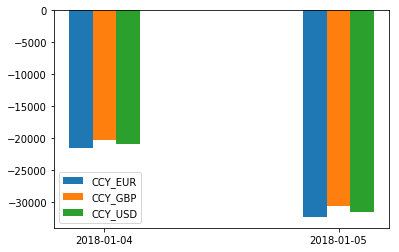

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

ind = np.arange(chart_data.columns.size)
width = 0.1

fig, ax = plt.subplots()

for ccy, x in zip(chart_data.index, [-.2, 0, .2]):
    ax.bar(ind + x/2, chart_data.loc[ccy,:].astype(object), width, label=ccy)
    
ax.set_xticks(ind)
ax.set_xticklabels(chart_data.columns.values)
ax.legend()

plt.show()